**Problem Statement**

**Prediction Salary** 

# Import

In [56]:
#data stuff
import pandas as pd

#Modelling
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction import text
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

#NLP
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
# from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import gensim

#other
from tqdm import tqdm_notebook
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

## Check the data

In [57]:

data = pd.read_csv('./data/san-francisco-payroll_2011-2019.csv',low_memory=False)
data.head(2)

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
0,Janet Lee Miller,Court Staff Attorney II,0.0,0.0,0.0,0.0,0.00,0.00,2019,PT
1,Gary Mar,Electrical Transit System Mech,97354.53,6996.5,2380.0,38855.9,106731.03,145586.93,2019,FT


## EDA

In [58]:
data.Year.value_counts()

2019    44525
2018    42309
2017    41566
2016    40970
2015    39387
2014    38119
2013    37606
2012    36766
2011    36159
Name: Year, dtype: int64

In [81]:
(data.groupby(by='Employee Name')['Job Title'].count()>5).sum()

27556

In [60]:
data['Employee Name']=data['Employee Name'].map(str.upper).map(str.strip).replace('  ',' ', regex=True).replace('[^A-Za-z0-9 ]', '', regex=True)
data['Job Title']=data['Job Title'].map(str.upper).map(str.strip).replace('  ',' ', regex=True).replace('[^A-Za-z ]', '', regex=True)
data

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
0,JANET LEE MILLER,COURT STAFF ATTORNEY II,0.0,0.0,0.0,0.0,0.00,0.00,2019,PT
1,GARY MAR,ELECTRICAL TRANSIT SYSTEM MECH,97354.53,6996.5,2380.0,38855.9,106731.03,145586.93,2019,FT
2,CHECIL A SALVOSA,LICENSED VOCATIONAL NURSE,86118.0,17212.96,7272.08,34942.38,110603.04,145545.42,2019,FT
3,KRISTIAN C SMOCK,STATIONARY ENG SEWAGE PLANT,106816.03,0.0,0.0,38729.65,106816.03,145545.68,2019,FT
4,YUN Y CHANG,PHARMACY TECHNICIAN,94039.13,14947.99,1241.69,35330.26,110228.81,145559.07,2019,FT
...,...,...,...,...,...,...,...,...,...,...
357402,HOWARD CHUCK,CUSTODIAN,46106.73,890.49,4839.07,Not Provided,51836.29,51836.29,2011,NaN
357403,BING KEUNG MAK,CUSTODIAN,48472.4,1972.35,1390.5,Not Provided,51835.25,51835.25,2011,NaN
357404,QIN MING ZHU,CUSTODIAN,46046.29,1853.97,3934.44,Not Provided,51834.70,51834.70,2011,NaN
357405,JOSE ALONZO,CUSTODIAN,47798.87,0.0,4032.55,Not Provided,51831.42,51831.42,2011,NaN


In [61]:
df=data[['Employee Name', 'Job Title', 'Total Pay & Benefits', 'Year', 'Status']]
df.columns=['Employee Name', 'Job Title', 'Salary', 'Year', 'Status']
df=df[df['Salary']!=0.0]
df

,Employee Name,Job Title,Salary,Year,Status
1,GARY MAR,ELECTRICAL TRANSIT SYSTEM MECH,145586.93,2019,FT
2,CHECIL A SALVOSA,LICENSED VOCATIONAL NURSE,145545.42,2019,FT
3,KRISTIAN C SMOCK,STATIONARY ENG SEWAGE PLANT,145545.68,2019,FT
4,YUN Y CHANG,PHARMACY TECHNICIAN,145559.07,2019,FT
5,DANIEL AGUADA,AUTOMOTIVE MECHANIC,145568.96,2019,FT
...,...,...,...,...,...
357402,HOWARD CHUCK,CUSTODIAN,51836.29,2011,NaN
357403,BING KEUNG MAK,CUSTODIAN,51835.25,2011,NaN
357404,QIN MING ZHU,CUSTODIAN,51834.70,2011,NaN
357405,JOSE ALONZO,CUSTODIAN,51831.42,2011,NaN


In [62]:
start_salary=df.sort_values(by='Year').groupby(by='Employee Name').agg({'Salary':'first', 'Year':'first'}).reset_index()
start_salary.columns=['Employee Name', 'Start Salary', 'Start Year']
start_salary

,Employee Name,Start Salary,Start Year
0,A BERNARD FATOOH,20039.91,2011
1,A ELIZABETH MARCHASIN,26282.86,2011
2,A JAMES ROBERTSON II,19473.92,2011
3,A JAMIL NIAZI,87496.21,2011
4,A K FINIZIO,26113.37,2014
...,...,...,...
94077,ZURHI N CHICUATA,3205.74,2017
94078,ZURI JONES,70888.04,2011
94079,ZURI S CHAVARIN CERDA,5941.65,2017
94080,ZUZANNA E CZERW,3594.04,2017


In [63]:
merge_df=df.merge(start_salary, on ='Employee Name', how='left').sort_values(['Employee Name','Year']).reset_index(drop=True)
merge_df.columns=['Employee Name', 'Job Title', 'End Salary', 'End Year', 'Status','Start Salary', 'Start Year']
merge_df

,Employee Name,Job Title,End Salary,End Year,Status,Start Salary,Start Year
0,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,20039.91,2011,NaN,20039.91,2011
1,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,23514.85,2012,NaN,20039.91,2011
2,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,29379.24,2013,NaN,20039.91,2011
3,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,30153.03,2014,PT,20039.91,2011
4,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,33363.71,2015,PT,20039.91,2011
...,...,...,...,...,...,...,...
357343,ZURI JONES,DEPUTY PROBATION OFFICER,86066.55,2019,PT,70888.04,2011
357344,ZURI S CHAVARIN CERDA,PUBLIC SERVICE TRAINEE,5941.65,2017,PT,5941.65,2017
357345,ZUZANNA E CZERW,PUBL SVC AIDEASST TO PROF,3594.04,2017,PT,3594.04,2017
357346,ZUZANNA E CZERW,PUBL SVC AIDEASST TO PROF,3331.77,2018,PT,3594.04,2017


In [64]:
merge_df['Total Year']=merge_df['End Year']-merge_df['Start Year']
merge_df

,Employee Name,Job Title,End Salary,End Year,Status,Start Salary,Start Year,Total Year
0,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,20039.91,2011,NaN,20039.91,2011,0
1,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,23514.85,2012,NaN,20039.91,2011,1
2,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,29379.24,2013,NaN,20039.91,2011,2
3,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,30153.03,2014,PT,20039.91,2011,3
4,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,33363.71,2015,PT,20039.91,2011,4
...,...,...,...,...,...,...,...,...
357343,ZURI JONES,DEPUTY PROBATION OFFICER,86066.55,2019,PT,70888.04,2011,8
357344,ZURI S CHAVARIN CERDA,PUBLIC SERVICE TRAINEE,5941.65,2017,PT,5941.65,2017,0
357345,ZUZANNA E CZERW,PUBL SVC AIDEASST TO PROF,3594.04,2017,PT,3594.04,2017,0
357346,ZUZANNA E CZERW,PUBL SVC AIDEASST TO PROF,3331.77,2018,PT,3594.04,2017,1


In [65]:
merge_df['Increase Percentage']=round((merge_df['End Salary']-merge_df['Start Salary'])/merge_df['Start Salary']*100,2)
merge_df=merge_df[merge_df['Total Year']!=0].reset_index(drop=True)
merge_df

,Employee Name,Job Title,End Salary,End Year,Status,Start Salary,Start Year,Total Year,Increase Percentage
0,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,23514.85,2012,NaN,20039.91,2011,1,17.34
1,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,29379.24,2013,NaN,20039.91,2011,2,46.60
2,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,30153.03,2014,PT,20039.91,2011,3,50.46
3,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,33363.71,2015,PT,20039.91,2011,4,66.49
4,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,37594.90,2016,NaN,20039.91,2011,5,87.60
...,...,...,...,...,...,...,...,...,...
259514,ZURI JONES,DEPUTY PROBATION OFFICER,142176.10,2016,NaN,70888.04,2011,5,100.56
259515,ZURI JONES,DEPUTY PROBATION OFFICER,148041.92,2017,FT,70888.04,2011,6,108.84
259516,ZURI JONES,DEPUTY PROBATION OFFICER,136547.78,2018,FT,70888.04,2011,7,92.62
259517,ZURI JONES,DEPUTY PROBATION OFFICER,86066.55,2019,PT,70888.04,2011,8,21.41


In [66]:
merge_df.columns

Index(['Employee Name', 'Job Title', 'End Salary', 'End Year', 'Status',
       'Start Salary', 'Start Year', 'Total Year', 'Increase Percentage'],
      dtype='object')

In [67]:
merge_df=merge_df[['Employee Name', 'Job Title', 'Status','Start Salary', 'Start Year', 'End Salary', 'End Year', 'Total Year', 'Increase Percentage']]

In [68]:
merge_df

,Employee Name,Job Title,Status,Start Salary,Start Year,End Salary,End Year,Total Year,Increase Percentage
0,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,NaN,20039.91,2011,23514.85,2012,1,17.34
1,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,NaN,20039.91,2011,29379.24,2013,2,46.60
2,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,PT,20039.91,2011,30153.03,2014,3,50.46
3,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,PT,20039.91,2011,33363.71,2015,4,66.49
4,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,NaN,20039.91,2011,37594.90,2016,5,87.60
...,...,...,...,...,...,...,...,...,...
259514,ZURI JONES,DEPUTY PROBATION OFFICER,NaN,70888.04,2011,142176.10,2016,5,100.56
259515,ZURI JONES,DEPUTY PROBATION OFFICER,FT,70888.04,2011,148041.92,2017,6,108.84
259516,ZURI JONES,DEPUTY PROBATION OFFICER,FT,70888.04,2011,136547.78,2018,7,92.62
259517,ZURI JONES,DEPUTY PROBATION OFFICER,PT,70888.04,2011,86066.55,2019,8,21.41


# Adding Carrer Level & Type

In [69]:
# %%bash
# pip install fuzzywuzzy 
# pip install plotly 
# pip install gensim 
# pip install webcolors

In [70]:
all_career = dict({
    'Firefighter': ['fire'],
    
    'Police': ['police', 'sherif', 'probation', 'sergeant', 'officer', 'lieutenant','traffic','investigator','cop','street','inspection'],
    
    'Transit': ['mta', 'transit', 'truck','wharf','receiver'],
    
    'Medical': ['anesth', 'medical', 'nurs', 'health', 'physician','chemist','hygienist',
             'orthopedic', 'health', 'pharm', 'care','CNSLR','cnslr','mental',
                'disease','therapist','counselor','curator','clincal','psychologist',
                'rehabilitation','dietitian','pharmacy','epidemiologist','nutritionist','dental',
                'forensic','dentist','hospital','acupuncturist','carrier'],
    
    'Animal': ['animal'],
    'Architectural': ['architect', 'inspector'],
    'Parking': ['parking','park'],
    'Technician':['technician','welders','locksmith','maintenance','mechanic','meter','glazier',
                  'welder','cement','floor','cable','steamfitter','roofer'],
    'Public Works': ['public works'],
    'Custodian': ['custodian','public safety','safety', 'guard'],
    'Engineering': ['engineer', 'engr', 'eng','automotive'],
    'Accountant': ['account','finance','payment','payroll','acc','cfo','accountant','cashier','auditor','cost'],
    'General Laborer': ['general laborer','carpenter', 'electrician', 'plumber',  'clerk', 'porter',
                        'worker','clean','cleaner','storekeeper','asphalt'],
    
    'Communications':['communications','speacker','recreation','preparator','reception','customer service'],
    'Administ': ['aide', 'assistant', 'secretary', 'attendant','adm','admin','administrator'
                 ,'plan','vendor','coordinate','support','coordinator','coordinater','helper','service'],
    'Data': ['analyst', 'data','auto','ml','ai', 'program','tech','mediasecurity'],
    'Airport': ['airport'],
    'Operator': ['admin', 'adm','operate','operater','operator','operation','assistant','survey','purchaser'
              ,'registrar','purchase','clerk','asst','Relation'], 
    'Court': ['attorney', 'lawyer','attorney','court', 'legal','law','probate','criminal'],
    'Public Service':['public service','Social Worker','Public Relations','mgr','Employee Relations'],
    'Food Service': ['food','cook','chef','baker'],
    'Real Estate':['real estate','asset', 'property'],
    'Sicience':['water','bio','quality','pathologist'],
    'Instructor':['Teacher','training','instruction','librar','instructor'],
    'Management':['manager','special','supervisor','planer','director','mayor','community','mayoral','planer','mgm','citizen','human'],
    'Farmer':['farmer','garden','garden','tree'],
    'Artist':['artist', 'painter','porter','graphic','photographer','art','designer','beautician'],
    'Transcriber':['transcriber','sonographer'],
    'Not provided':['not provide']
})

all_level = dict({
    'Manager': ['manager', 'chief'],
    'Senior': ['senior'],
    'Junior': ['Junior'],
    'Trainee': ['trainee'],
    'Not provided':['not provide']
})

def find_job_field(row):
    for field, field_key in all_career.items():
        for key in field_key:
            if key in row.lower():
                return field
    return "Other"

def find_job_level(row):
    for field, field_key in all_level.items():
        for key in field_key:
            if key in row.lower():
                return field
    return "Staff"

def fuzzy_job_field(row):
    strOptions = row.lower().split()
    for field, field_key in all_career.items():
        for key in field_key:
            highest= process.extractOne(key,strOptions)
            if highest[1] > 90:
                return field
    return "Other"

def fuzzy_job_level(row):
    strOptions = row.lower().split()
    for field, field_key in all_career.items():
        for key in field_key:
            highest= process.extractOne(key,strOptions)
            if highest[1] > 90:
                return field
    return "Staff"

#Map Extract
merge_df['Career'] = merge_df['Job Title'].map(find_job_field)
merge_df['Level'] = merge_df['Job Title'].map(find_job_level)
# df['Career'] = df['JobTitle'].map(fuzzy_job_field)
# df['Level'] = df['JobTitle'].map(fuzzy_job_level)

# df[df['JobTitle'].str.lower().str.contains('food serv')].JobTitle

merge_df.head()

/var/folders/74/zq1vl5mj4518hvqv44mrtkd80000gn/T/ipykernel_10437/1320529939.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_df['Career'] = merge_df['Job Title'].map(find_job_field)
/var/folders/74/zq1vl5mj4518hvqv44mrtkd80000gn/T/ipykernel_10437/1320529939.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_df['Level'] = merge_df['Job Title'].map(find_job_level)


,Employee Name,Job Title,Status,Start Salary,Start Year,End Salary,End Year,Total Year,Increase Percentage,Career,Level
0,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,NaN,20039.91,2011,23514.85,2012,1,17.34,Police,Staff
1,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,NaN,20039.91,2011,29379.24,2013,2,46.60,Police,Staff
2,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,PT,20039.91,2011,30153.03,2014,3,50.46,Police,Staff
3,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,PT,20039.91,2011,33363.71,2015,4,66.49,Police,Staff
4,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,NaN,20039.91,2011,37594.90,2016,5,87.60,Police,Staff


In [71]:
merge_df.Career.value_counts()

Medical            48687
Police             32323
General Laborer    30035
Transit            25198
Administ           22594
Engineering        14644
Data               11664
Custodian          11008
Firefighter        10991
Management         10065
Technician          7159
Communications      6688
Accountant          5690
Other               3996
Instructor          3972
Architectural       3578
Court               3544
Farmer              2171
Public Works        1987
Operator            1655
Sicience             637
Parking              594
Food Service         259
Artist               127
Real Estate           96
Public Service        63
Transcriber           59
Animal                25
Not provided          10
Name: Career, dtype: int64

In [75]:
merge_df['End Salary']

0          23514.85
1          29379.24
2          30153.03
3          33363.71
4          37594.90
            ...    
259514    142176.10
259515    148041.92
259516    136547.78
259517     86066.55
259518      3331.77
Name: End Salary, Length: 259519, dtype: float64

In [52]:
merge_df.Level.value_counts()

Staff      233243
Senior      14651
Manager      8987
Trainee      2628
Other          10
Name: Level, dtype: int64

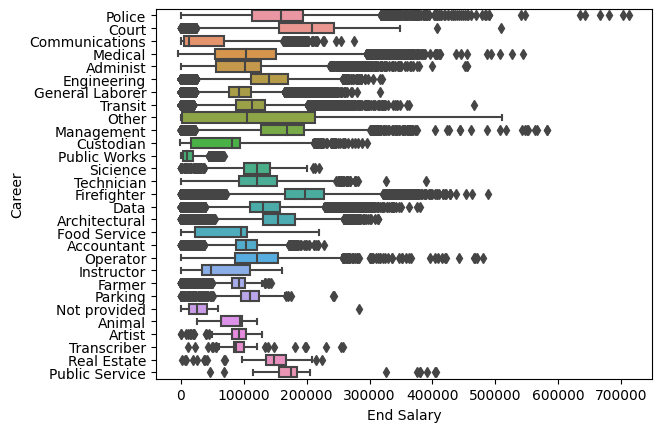

In [82]:
sns.boxplot(x='End Salary', y="Career", data = merge_df);

In [21]:
# Check other job to 
merge_df[merge_df['Career'].str.contains("Other")]

,Employee Name,Job Title,Status,Start Salary,Start Year,End Salary,End Year,Total Year,Increase Percentage,Career,Level
28,AAREONA S MILES,DA INVESTIGATIVE ASSIST,FT,5898.01,2018,72802.63,2019,1,1134.36,Other,Staff
188,AARON HYLAND,BDCOMM MBR GRPMMTG,PT,404.00,2013,1072.39,2014,1,165.44,Other,Staff
189,AARON HYLAND,BDCOMM MBR GRP MMTG,PT,404.00,2013,8810.52,2015,2,2080.82,Other,Staff
190,AARON HYLAND,BDCOMM MBR GRP MMTG,NaN,404.00,2013,2600.63,2016,3,543.72,Other,Staff
191,AARON HYLAND,BDCOMM MBR GRP MMTG,PT,404.00,2013,959.50,2017,4,137.50,Other,Staff
...,...,...,...,...,...,...,...,...,...,...,...
257200,YOSEF S TAHBAZOF,COMMISSIONER NO BENEFITS,PT,4747.00,2014,1212.00,2018,4,-74.47,Other,Staff
257201,YOSEF S TAHBAZOF,COMMISSIONER NO BENEFITS,PT,4747.00,2014,1464.50,2019,5,-69.15,Other,Staff
259397,ZOE R BURTON,VOLUNTEEROUTREACH COORD,PT,44220.13,2013,74252.74,2014,1,67.92,Other,Staff
259398,ZOE R BURTON,VOLUNTEEROUTREACH COORD,FT,44220.13,2013,95437.84,2015,2,115.82,Other,Staff


In [22]:
idx_replace=merge_df[merge_df['Career'].str.contains("Not provided")].index

In [23]:
merge_df.iloc[idx_replace,:]=merge_df.iloc[idx_replace,:].replace("Not provided","Other")

In [24]:
merge_df.Level.value_counts()


Staff      233243
Senior      14651
Manager      8987
Trainee      2628
Other          10
Name: Level, dtype: int64

In [25]:
merge_df.Career.value_counts()


Medical            48687
Police             32323
General Laborer    30035
Transit            25198
Administ           22594
Engineering        14644
Data               11664
Custodian          11008
Firefighter        10991
Management         10065
Technician          7159
Communications      6688
Accountant          5690
Other               4006
Instructor          3972
Architectural       3578
Court               3544
Farmer              2171
Public Works        1987
Operator            1655
Sicience             637
Parking              594
Food Service         259
Artist               127
Real Estate           96
Public Service        63
Transcriber           59
Animal                25
Name: Career, dtype: int64

In [26]:
merge_df.columns

Index(['Employee Name', 'Job Title', 'Status', 'Start Salary', 'Start Year',
       'End Salary', 'End Year', 'Total Year', 'Increase Percentage', 'Career',
       'Level'],
      dtype='object')

In [27]:
main_df=merge_df[['Status', 'Total Year', 'Increase Percentage','Start Salary','End Salary',
    'Level', 'Career']]
main_df

,Status,Total Year,Increase Percentage,Start Salary,End Salary,Level,Career
0,NaN,1,17.34,20039.91,23514.85,Staff,Police
1,NaN,2,46.60,20039.91,29379.24,Staff,Police
2,PT,3,50.46,20039.91,30153.03,Staff,Police
3,PT,4,66.49,20039.91,33363.71,Staff,Police
4,NaN,5,87.60,20039.91,37594.90,Staff,Police
...,...,...,...,...,...,...,...
259514,NaN,5,100.56,70888.04,142176.10,Staff,Police
259515,FT,6,108.84,70888.04,148041.92,Staff,Police
259516,FT,7,92.62,70888.04,136547.78,Staff,Police
259517,PT,8,21.41,70888.04,86066.55,Staff,Police


In [28]:
main_df.corr()

,Total Year,Increase Percentage,Start Salary,End Salary
Total Year,1.000000,0.003144,0.096843,0.172533
Increase Percentage,0.003144,1.000000,-0.062763,-0.006260
Start Salary,0.096843,-0.062763,1.000000,0.659564
End Salary,0.172533,-0.006260,0.659564,1.000000


In [29]:
main_df.columns=['Status', 'Total_Year', 'Increase_Percentage','Start_Salary',  'End_Salary', 'Level',
       'Career']
main_df.columns

Index(['Status', 'Total_Year', 'Increase_Percentage', 'Start_Salary',
       'End_Salary', 'Level', 'Career'],
      dtype='object')

In [30]:
import statsmodels.formula.api as smf
# NB. unlike sm.OLS, there is "intercept" term is included here
model1=smf.ols(formula="End_Salary ~  Total_Year +C(Level) + C(Career)", data=main_df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             End_Salary   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     3774.
Date:                Fri, 11 Nov 2022   Prob (F-statistic):               0.00
Time:                        11:25:58   Log-Likelihood:            -3.2026e+06
No. Observations:              259519   AIC:                         6.405e+06
Df Residuals:                  259486   BIC:                         6.406e+06
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     1.554e+05   1083.719    143.374      0.000    1.53e+05    1.58e+05
C(Level)[T.Other]            -1.412e+05   1.75e+04     -8.049      0.000   -1.76e+05   -1.07e+05
C(Level)[T.Senior]           -6.174e+04    905.418    -68.191      0.000   -6.35e+04      -6e+04
C(Level)[T.Staff]            -7.052e+04    776.616    -90.805      0.000    -7.2e+04    -6.9e+04
C(Level)[T.Trainee]          -1.458e+05   1374.761   -106.023      0.000   -1.48e+05   -1.43e+05
C(Career)[T.Administ]          902.6319    831.178      1.086      0.277    -726.454    2531.718
C(Career)[T.Animal]           -1.16e+04   1.11e+04     -1.045      0.296   -3.33e+04    1.02e+04
C(Career)[T.Architectural]    5.117e+04   1181.888     43.294      0.000    4.89e+04    5.35e+04
C(Career)[T.Artist]          -1.056e+04   4968.098     -2.125      0.034   -2.03e+04    -822.027
C(Career)[T.Communications]   -6.15e+04   1002.509    -61.348      0.000   -6.35e+04   -5.95e+04
C(Career)[T.Court]            9.233e+04   1188.099     77.714      0.000       9e+04    9.47e+04
C(Career)[T.Custodian]       -3.167e+04    908.385    -34.861      0.000   -3.34e+04   -2.99e+04
C(Career)[T.Data]              3.05e+04    895.378     34.069      0.000    2.87e+04    3.23e+04
C(Career)[T.Engineering]       3.11e+04    866.658     35.885      0.000    2.94e+04    3.28e+04
C(Career)[T.Farmer]          -1.448e+04   1399.512    -10.348      0.000   -1.72e+04   -1.17e+04
C(Career)[T.Firefighter]      9.239e+04    908.701    101.671      0.000    9.06e+04    9.42e+04
C(Career)[T.Food Service]    -2.642e+04   3518.678     -7.508      0.000   -3.33e+04   -1.95e+04
C(Career)[T.General Laborer]  -1.08e+04    800.503    -13.498      0.000   -1.24e+04   -9235.848
C(Career)[T.Instructor]      -3.673e+04   1148.247    -31.986      0.000    -3.9e+04   -3.45e+04
C(Career)[T.Management]       1.639e+04   1034.468     15.840      0.000    1.44e+04    1.84e+04
C(Career)[T.Medical]          6251.1252    779.589      8.018      0.000    4723.152    7779.098
C(Career)[T.Operator]         1.786e+04   1546.605     11.550      0.000    1.48e+04    2.09e+04
C(Career)[T.Other]            1.641e+04   1145.945     14.322      0.000    1.42e+04    1.87e+04
C(Career)[T.Parking]            43.3634   2388.920      0.018      0.986   -4638.856    4725.583
C(Career)[T.Police]           5.283e+04    799.246     66.095      0.000    5.13e+04    5.44e+04
C(Career)[T.Public Service]   8.774e+04   7014.235     12.509      0.000     7.4e+04    1.01e+05
C(Career)[T.Public Works]    -7.728e+04   1448.706    -53.345      0.000   -8.01e+04   -7.44e+04
C(Career)[T.Real Estate]     -1.831e+04   5736.531     -3.192      0.001   -2.96e+04   -7064.773
C(Career)[T.Sicience]         1.518e+04   2314.223      6.560      0.000    

In [31]:
model1=smf.ols(formula="Increase_Percentage ~  Total_Year +C(Level) + C(Career)", data=main_df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Increase_Percentage   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                  0.000
Method:                  Least Squares   F-statistic:                     2.154
Date:                 Fri, 11 Nov 2022   Prob (F-statistic):           0.000163
Time:                         11:26:00   Log-Likelihood:            -2.5099e+06
No. Observations:               259519   AIC:                         5.020e+06
Df Residuals:                   259486   BIC:                         5.020e+06
Df Model:                           32                                         
Covariance Type:             nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       16.5403     75.098      0.220      0.826    -130.649     163.730
C(Level)[T.Other]              146.4464   1215.882      0.120      0.904   -2236.649    2529.541
C(Level)[T.Senior]             219.3662     62.742      3.496      0.000      96.393     342.339
C(Level)[T.Staff]              113.8216     53.817      2.115      0.034       8.342     219.301
C(Level)[T.Trainee]            120.8876     95.266      1.269      0.204     -65.831     307.606
C(Career)[T.Administ]           92.4497     57.598      1.605      0.108     -20.440     205.339
C(Career)[T.Animal]           -134.2914    769.010     -0.175      0.861   -1641.530    1372.947
C(Career)[T.Architectural]     -56.7204     81.901     -0.693      0.489    -217.243     103.802
C(Career)[T.Artist]            -55.8129    344.271     -0.162      0.871    -730.575     618.949
C(Career)[T.Communications]    171.3719     69.470      2.467      0.014      35.212     307.532
C(Career)[T.Court]             -36.1392     82.331     -0.439      0.661    -197.506     125.227
C(Career)[T.Custodian]         155.2244     62.948      2.466      0.014      31.848     278.600
C(Career)[T.Data]              -12.2767     62.046     -0.198      0.843    -133.886     109.333
C(Career)[T.Engineering]         8.9464     60.056      0.149      0.882    -108.762     126.655
C(Career)[T.Farmer]             -3.0423     96.981     -0.031      0.975    -193.122     187.038
C(Career)[T.Firefighter]       -26.7707     62.970     -0.425      0.671    -150.189      96.648
C(Career)[T.Food Service]       -0.4095    243.831     -0.002      0.999    -478.312     477.493
C(Career)[T.General Laborer]    23.3617     55.472      0.421      0.674     -85.362     132.085
C(Career)[T.Instructor]         45.9658     79.569      0.578      0.563    -109.988     201.919
C(Career)[T.Management]         73.2859     71.685      1.022      0.307     -67.214     213.786
C(Career)[T.Medical]            38.9678     54.023      0.721      0.471     -66.915     144.851
C(Career)[T.Operator]          -62.6528    107.174     -0.585      0.559    -272.711     147.405
C(Career)[T.Other]              59.7813     79.410      0.753      0.452     -95.860     215.422
C(Career)[T.Parking]            23.7624    165.543      0.144      0.886    -300.698     348.223
C(Career)[T.Police]            -48.6998     55.385     -0.879      0.379    -157.252      59.853
C(Career)[T.Public Service]    -87.6722    486.061     -0.180      0.857   -1040.338     864.994
C(Career)[T.Public Works]      124.0264    100.390      1.235      0.217     -72.735     320.788
C(Career)[T.Real Estate]        84.9255    397.520      0.214      0.831    -694.204     864.055
C(Career)[T.Sicience]            9.1479    160.367      0.057    

In [32]:
main_df

,Status,Total_Year,Increase_Percentage,Start_Salary,End_Salary,Level,Career
0,NaN,1,17.34,20039.91,23514.85,Staff,Police
1,NaN,2,46.60,20039.91,29379.24,Staff,Police
2,PT,3,50.46,20039.91,30153.03,Staff,Police
3,PT,4,66.49,20039.91,33363.71,Staff,Police
4,NaN,5,87.60,20039.91,37594.90,Staff,Police
...,...,...,...,...,...,...,...
259514,NaN,5,100.56,70888.04,142176.10,Staff,Police
259515,FT,6,108.84,70888.04,148041.92,Staff,Police
259516,FT,7,92.62,70888.04,136547.78,Staff,Police
259517,PT,8,21.41,70888.04,86066.55,Staff,Police


In [33]:
df_testing=main_df[['Total_Year','Level','Career','Start_Salary']]
df_testing

,Total_Year,Level,Career,Start_Salary
0,1,Staff,Police,20039.91
1,2,Staff,Police,20039.91
2,3,Staff,Police,20039.91
3,4,Staff,Police,20039.91
4,5,Staff,Police,20039.91
...,...,...,...,...
259514,5,Staff,Police,70888.04
259515,6,Staff,Police,70888.04
259516,7,Staff,Police,70888.04
259517,8,Staff,Police,70888.04


In [34]:
df_testing.drop_duplicates(subset=['Level','Career','Start_Salary'],inplace=True)
df_testing

/var/folders/74/zq1vl5mj4518hvqv44mrtkd80000gn/T/ipykernel_10437/1650446236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testing.drop_duplicates(subset=['Level','Career','Start_Salary'],inplace=True)


,Total_Year,Level,Career,Start_Salary
0,1,Staff,Police,20039.91
8,1,Staff,Court,19473.92
11,1,Staff,Communications,26113.37
16,1,Staff,Medical,121348.48
17,1,Staff,Administ,2622.32
...,...,...,...,...
259505,1,Staff,Custodian,49456.33
259506,1,Staff,Custodian,80932.30
259509,1,Staff,Communications,5943.15
259510,1,Staff,Police,70888.04


In [35]:
model2=smf.ols(formula="Start_Salary ~  C(Level) + C(Career)", data=df_testing).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Start_Salary   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     1042.
Date:                Fri, 11 Nov 2022   Prob (F-statistic):               0.00
Time:                        11:26:01   Log-Likelihood:            -9.6814e+05
No. Observations:               79189   AIC:                         1.936e+06
Df Residuals:                   79157   BIC:                         1.937e+06
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     1.243e+05   1696.947     73.266      0.000    1.21e+05    1.28e+05
C(Level)[T.Other]            -7.303e+04   1.57e+04     -4.646      0.000   -1.04e+05   -4.22e+04
C(Level)[T.Senior]           -5.481e+04   1393.601    -39.330      0.000   -5.75e+04   -5.21e+04
C(Level)[T.Staff]            -5.936e+04   1197.994    -49.550      0.000   -6.17e+04    -5.7e+04
C(Level)[T.Trainee]          -1.062e+05   1724.247    -61.599      0.000    -1.1e+05   -1.03e+05
C(Career)[T.Administ]        -4471.9465   1337.064     -3.345      0.001   -7092.584   -1851.309
C(Career)[T.Animal]           1.206e+04   1.65e+04      0.731      0.465   -2.03e+04    4.44e+04
C(Career)[T.Architectural]    4.946e+04   1881.983     26.282      0.000    4.58e+04    5.32e+04
C(Career)[T.Artist]          -9681.5893   7226.451     -1.340      0.180   -2.38e+04    4482.211
C(Career)[T.Communications]  -4.066e+04   1561.602    -26.037      0.000   -4.37e+04   -3.76e+04
C(Career)[T.Court]            6.109e+04   1935.473     31.564      0.000    5.73e+04    6.49e+04
C(Career)[T.Custodian]       -1.935e+04   1498.515    -12.915      0.000   -2.23e+04   -1.64e+04
C(Career)[T.Data]             2.568e+04   1441.994     17.805      0.000    2.28e+04    2.85e+04
C(Career)[T.Engineering]      1.791e+04   1412.256     12.683      0.000    1.51e+04    2.07e+04
C(Career)[T.Farmer]          -6969.6490   2234.550     -3.119      0.002   -1.13e+04   -2589.944
C(Career)[T.Firefighter]      9.126e+04   1512.660     60.334      0.000    8.83e+04    9.42e+04
C(Career)[T.Food Service]    -1.882e+04   5488.742     -3.428      0.001   -2.96e+04   -8058.005
C(Career)[T.General Laborer] -4223.6157   1300.331     -3.248      0.001   -6772.256   -1674.975
C(Career)[T.Instructor]      -2.392e+04   1808.198    -13.228      0.000   -2.75e+04   -2.04e+04
C(Career)[T.Management]       1.346e+04   1645.798      8.178      0.000    1.02e+04    1.67e+04
C(Career)[T.Medical]          1.786e+04   1284.048     13.913      0.000    1.53e+04    2.04e+04
C(Career)[T.Operator]         2.075e+04   2344.769      8.848      0.000    1.61e+04    2.53e+04
C(Career)[T.Other]            3.828e+04   1872.994     20.437      0.000    3.46e+04    4.19e+04
C(Career)[T.Parking]          1.287e+04   3526.633      3.650      0.000    5958.389    1.98e+04
C(Career)[T.Police]           4.921e+04   1313.295     37.473      0.000    4.66e+04    5.18e+04
C(Career)[T.Public Service]   6.568e+04   1.08e+04      6.060      0.000    4.44e+04    8.69e+04
C(Career)[T.Public Works]    -5.146e+04   1740.684    -29.561      0.000   -5.49e+04    -4.8e+04
C(Career)[T.Real Estate]     -1.908e+04   9461.376     -2.017      0.044   -3.76e+04    -536.516
C(Career)[T.Sicience]         1.725e+04   3796.585      4.543      0.000    

In [36]:
## Model with End Salary + Encoding

In [37]:
X=main_df[['Total_Year','Level', 'Career']]
y=main_df['End_Salary']

In [38]:
offset = int(X.shape[0] * 0.8)

X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

In [39]:
X_train_transform=X_train.copy()
from sklearn.preprocessing import OneHotEncoder
enc_level = OneHotEncoder(handle_unknown='ignore',sparse=False)
enc_level.fit(X_train[['Level']])
level_cat=enc_level.categories_[0]
for x in range(len(level_cat)):
    X_train_transform[level_cat[x]]=enc_level.transform(X_train[['Level']]).T[x]
enc_career = OneHotEncoder(handle_unknown='ignore',sparse=False)
enc_career.fit(X_train[['Career']])
career_cat=enc_career.categories_[0]
for x in range(len(career_cat)):
    X_train_transform[career_cat[x]]=enc_career.transform(X_train[['Career']]).T[x]
X_train_transform=X_train_transform.drop(columns=['Level','Career'])
X_train_transform

,Total_Year,Manager,Other,Senior,Staff,Trainee,Accountant,Administ,Animal,Architectural,...,Operator,Parking,Police,Public Service,Public Works,Real Estate,Sicience,Technician,Transcriber,Transit
0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207610,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207611,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207612,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207613,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
X_test_transform=X_test.copy()
for x in range(len(level_cat)):
    X_test_transform[level_cat[x]]=enc_level.transform(X_test[['Level']]).T[x]
for x in range(len(career_cat)):
    X_test_transform[career_cat[x]]=enc_career.transform(X_test[['Career']]).T[x]
X_test_transform=X_test_transform.drop(columns=['Level','Career'])
X_test_transform

,Total_Year,Manager,Other,Senior,Staff,Trainee,Accountant,Administ,Animal,Architectural,...,Operator,Parking,Police,Public Service,Public Works,Real Estate,Sicience,Technician,Transcriber,Transit
207615,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207616,6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207617,6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207618,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207619,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259514,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259515,6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259516,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259517,8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
sclist=[]
for k in tqdm(range(2,15,2)):
    neigh = KNeighborsRegressor(n_neighbors=k)
    #neigh.fit(X_train, y_train)
    sc=cross_val_score(neigh , X_train_transform, y_train, cv=3).mean()
    sclist.append(sc)
sclist
# neigh.score(X_test, y_test )

100%|█████████████████████████████████████████████| 7/7 [04:44<00:00, 40.67s/it]


[0.02156309679690623,
 0.1562910526291735,
 0.228491231904115,
 0.24764441018548025,
 0.26298793956031885,
 0.27424900050419465,
 0.2778717497968947]

[0.02156309679690623,
 0.1562910526291735,
 0.228491231904115,
 0.24764441018548025,
 0.26298793956031885,
 0.27424900050419465,
 0.2778717497968947]

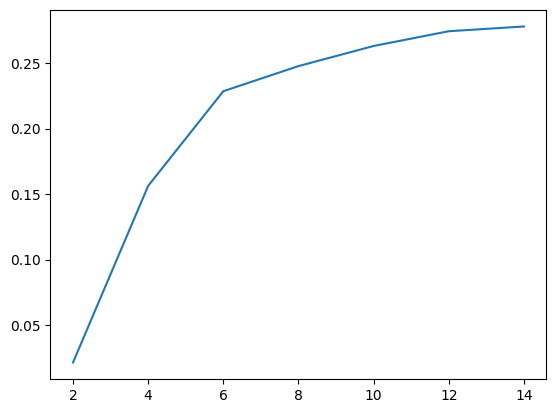

In [42]:
#END SALARY
krange=range(2,15,2)
plt.plot(krange,sclist)
sclist

In [43]:
for k in tqdm(range(15,30,4)):
    neigh = KNeighborsRegressor(n_neighbors=k)
    #neigh.fit(X_train, y_train)
    sc=cross_val_score(neigh , X_train_transform, y_train, cv=3).mean()
    sclist.append(sc)
sclist
# neigh.score(X_test, y_test )

100%|█████████████████████████████████████████████| 4/4 [02:40<00:00, 40.17s/it]


[0.02156309679690623,
 0.1562910526291735,
 0.228491231904115,
 0.24764441018548025,
 0.26298793956031885,
 0.27424900050419465,
 0.2778717497968947,
 0.28192614175066044,
 0.2909455333653823,
 0.2945186580298614,
 0.30061699456906815]

In [44]:
# #END SALARY
# krange=range(15,30,4)
# plt.plot(krange,sclist)
# sclist

## Model with Start Salary + Encoding

In [45]:
X=df_testing[['Total_Year','Level', 'Career']]
y=df_testing['Start_Salary']

In [46]:
offset = int(X.shape[0] * 0.8)

X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

In [47]:
X_train_transform=X_train.copy()
from sklearn.preprocessing import OneHotEncoder
enc_level = OneHotEncoder(handle_unknown='ignore',sparse=False)
enc_level.fit(X_train[['Level']])
level_cat=enc_level.categories_[0]
for x in range(len(level_cat)):
    X_train_transform[level_cat[x]]=enc_level.transform(X_train[['Level']]).T[x]
enc_career = OneHotEncoder(handle_unknown='ignore',sparse=False)
enc_career.fit(X_train[['Career']])
career_cat=enc_career.categories_[0]
for x in range(len(career_cat)):
    X_train_transform[career_cat[x]]=enc_career.transform(X_train[['Career']]).T[x]
X_train_transform=X_train_transform.drop(columns=['Level','Career'])
X_train_transform

,Total_Year,Manager,Other,Senior,Staff,Trainee,Accountant,Administ,Animal,Architectural,...,Operator,Parking,Police,Public Service,Public Works,Real Estate,Sicience,Technician,Transcriber,Transit
0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205990,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205991,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205992,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205993,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
X_test_transform=X_test.copy()
for x in range(len(level_cat)):
    X_test_transform[level_cat[x]]=enc_level.transform(X_test[['Level']]).T[x]
for x in range(len(career_cat)):
    X_test_transform[career_cat[x]]=enc_career.transform(X_test[['Career']]).T[x]
X_test_transform=X_test_transform.drop(columns=['Level','Career'])
X_test_transform

,Total_Year,Manager,Other,Senior,Staff,Trainee,Accountant,Administ,Animal,Architectural,...,Operator,Parking,Police,Public Service,Public Works,Real Estate,Sicience,Technician,Transcriber,Transit
206002,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206003,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
206008,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206009,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206010,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259505,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259506,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259509,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259510,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
sclist=[]
for k in tqdm(range(30,50)):
    neigh = KNeighborsRegressor(n_neighbors=k)
    #neigh.fit(X_train, y_train)
    sc=cross_val_score(neigh , X_train_transform, y_train, cv=3).mean()
    sclist.append(sc)
sclist
# neigh.score(X_test, y_test )

100%|███████████████████████████████████████████| 20/20 [01:19<00:00,  3.95s/it]


[0.2708856158547256,
 0.2691146554340979,
 0.2688452478707521,
 0.2673784718865255,
 0.26722293731693464,
 0.2651810355126966,
 0.2646740110441653,
 0.2628027379806856,
 0.26453926192154853,
 0.2648505487574725,
 0.26535924139034806,
 0.2675421546124492,
 0.265582837383761,
 0.2646008843247723,
 0.26324926015683126,
 0.26409550827916534,
 0.26279749381552814,
 0.2641175134641734,
 0.26129484908090794,
 0.2628366623782979]

[0.2708856158547256,
 0.2691146554340979,
 0.2688452478707521,
 0.2673784718865255,
 0.26722293731693464,
 0.2651810355126966,
 0.2646740110441653,
 0.2628027379806856,
 0.26453926192154853,
 0.2648505487574725,
 0.26535924139034806,
 0.2675421546124492,
 0.265582837383761,
 0.2646008843247723,
 0.26324926015683126,
 0.26409550827916534,
 0.26279749381552814,
 0.2641175134641734,
 0.26129484908090794,
 0.2628366623782979]

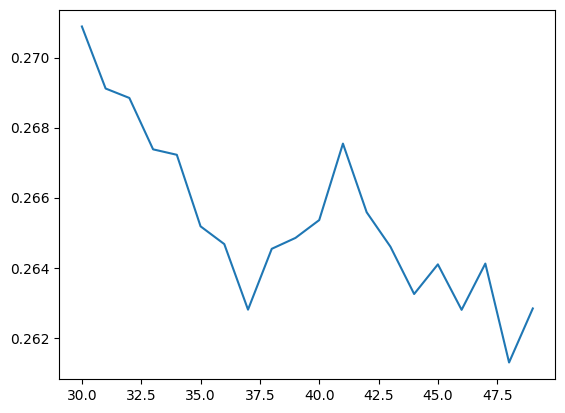

In [50]:
#END SALARY
krange=range(30,50)
plt.plot(krange,sclist)
sclist

In [51]:
# # check tpot version
# import tpot
# from tpot import TPOTRegressor
# tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)
# tpot.fit(X_train_transform, y_train)
# print(tpot.score(X_test_transform, y_test))